In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras import regularizers
from keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2
import os

In [2]:
image_path = '/kaggle/input/utkface-filtered-images'

**Завантаження зображень з папки, попередня обробка та формування набору даних (X — зображення, Y — мітки віку)**

In [3]:
width = 100
height = 100

X = []
Y = []

# Проходимо по всіх файлах в папці
for folder_name, _, filenames in os.walk(image_path):
    for file in filenames:
        # Створюємо повний шлях до файлу
        file_path = os.path.join(folder_name, file)
        
        # Отримуємо мітку віку з назви файлу (перша частина до символу '_')
        age = int(file.split('_')[0]) 
        
        # Відкриваємо зображення
        image = Image.open(file_path)
        image = image.convert('RGB')
        image = image.resize((width, height))
        
        # Додаємо зображення і мітку до відповідних списків
        X.append(np.array(image))
        Y.append(age)

X = np.array(X)
Y = np.array(Y)

print(f"Зображень: {X.shape[0]}, Міток: {Y.shape[0]}")

Зображень: 22459, Міток: 22459


**Нормалізація пікселів зображень до діапазону [0, 1]**

In [4]:
X = X.astype('float32')
X /= 255.0

print('Min: %.3f, Max: %.3f' % (X.min(), X.max()))

Min: 0.000, Max: 1.000


**Розбиття даних на тренувальний, валідаційний і тестовий набори з конверсією міток у float32**

In [ ]:
seed = 42
# Спочатку 70% train, 30% temp
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X, Y,
    test_size=0.3,
    random_state=seed,
    stratify=Y,
    shuffle=True
)

# Потім temp (30%) ділимо навпіл: 15% val, 15% test
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp,
    test_size=0.5,
    random_state=seed,
    stratify=Y_temp,
    shuffle=True
)

# Приводимо до потрібного типу (якщо треба для моделі)
Y_train = np.array(Y_train, dtype=np.float32)
Y_val = np.array(Y_val, dtype=np.float32)
Y_test = np.array(Y_test, dtype=np.float32)

print("Y_train shape:", Y_train.shape)
print("Y_val shape:", Y_val.shape)
print("Y_test shape:", Y_test.shape)


**Налаштування генераторів зображень: аугментація для тренувальних, без змін для тестових даних**

In [6]:
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

test_datagen = ImageDataGenerator()

**Налаштування callback-функцій та гіперпараметрів навчання**

In [7]:
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from timeit import default_timer as timer

# Callback для вимірювання часу тренування кожної епохи
class TimingCallback(Callback):
    def __init__(self):
        self.logs = []

    def on_epoch_begin(self, epoch, logs=None):
        self.starttime = timer()

    def on_epoch_end(self, epoch, logs=None):
        self.logs.append(timer() - self.starttime)

# Callback для ранньої зупинки навчання
early_stopping = EarlyStopping(
    patience=6,  # Чекаємо 6 епох перед зупинкою
    min_delta=0.01,  # Якщо зміни у втраті менші за 1%, зупиняємось
    verbose=1,
    mode='min',
    monitor='val_loss'
)

# Callback для зменшення learning rate при плато
reduce_learning_rate = ReduceLROnPlateau(
    monitor="val_loss",
    patience=5,  # Якщо val_loss не покращується 5 епох, зменшуємо lr
    factor=0.1,  # Зменшуємо learning rate у 10 разів
    cooldown=4,  # Чекаємо 4 епохи перед повторним зменшенням
    min_lr=1e-6,  # Мінімальне значення learning rate
    verbose=1
)

# Callback для вимірювання часу епох
time_callback = TimingCallback()

# Гіперпараметри
lr = 0.1
epochs = 30 
batch_size = 32
results = {}

**Кодування вікових значень у категорії та one-hot представлення**

In [8]:
import numpy as np
from tensorflow.keras.utils import to_categorical

Y_train_encoded = Y_train.flatten()
Y_val_encoded = Y_val.flatten()
Y_test_encoded = Y_test.flatten()

bins = [0, 9, 20, 26, 34, 45, 60, 100] 

Y_train_encoded = np.digitize(Y_train_encoded, bins, right=True) - 1
Y_val_encoded = np.digitize(Y_val_encoded, bins, right=True) - 1
Y_test_encoded = np.digitize(Y_test_encoded, bins, right=True) - 1

if np.max(Y_train_encoded) >= 7 or np.max(Y_val_encoded) >= 7 or np.max(Y_test_encoded) >= 7:
    print("Warning: There are values greater than or equal to 7!")

# Перетворення на one-hot encoding
Y_train_encoded = to_categorical(Y_train_encoded, num_classes=7)
Y_val_encoded = to_categorical(Y_val_encoded, num_classes=7)
Y_test_encoded = to_categorical(Y_test_encoded, num_classes=7)

print("After one-hot encoding - Y_train_encoded shape:", Y_train_encoded.shape)
print("After one-hot encoding - Y_val_encoded shape:", Y_val_encoded.shape)
print("After one-hot encoding - Y_test_encoded shape:", Y_test_encoded.shape)


Before digitize - Y_train shape: (15721,)
Before digitize - Y_val shape: (3369,)
Before digitize - Y_test shape: (3369,)
After flatten - Y_train_encoded shape: (15721,)
After flatten - Y_val_encoded shape: (3369,)
After flatten - Y_test_encoded shape: (3369,)
After digitize - Y_train_encoded shape: (15721,)
After digitize - Y_val_encoded shape: (3369,)
After digitize - Y_test_encoded shape: (3369,)
Max value in Y_train_encoded: 6
Max value in Y_val_encoded: 6
Max value in Y_test_encoded: 6
After one-hot encoding - Y_train_encoded shape: (15721, 7)
After one-hot encoding - Y_val_encoded shape: (3369, 7)
After one-hot encoding - Y_test_encoded shape: (3369, 7)


**Генератор навчальних даних з аугментацією для регресійної моделі**

In [ ]:
train_generator = train_datagen.flow(
    X_train, Y_train,
    batch_size=batch_size
)

**Побудова та навчання регресійної моделі на основі MobileNet**

In [11]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (BatchNormalization, GlobalAveragePooling2D, 
                                     Dropout, Dense)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.utils.class_weight import compute_class_weight
import pickle

input_shape = (100, 100)
base_mobilenet_model = MobileNet(
    input_shape=(input_shape[0], input_shape[1], 3),
    include_top=False,
    weights=None
)

mobilenet_model_reg = Sequential([
    BatchNormalization(input_shape=(input_shape[0], input_shape[1], 3)),
    base_mobilenet_model,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(1, activation='linear')
])

mobilenet_model_reg.compile(
    optimizer=Adam(),
    loss='mean_squared_error', 
    metrics=['mae']
)

# Навчання MobileNet
mobilenet_model_reg_history = mobilenet_model_reg.fit(
    train_generator,
    batch_size=batch_size,
    epochs=30,
    validation_data=(X_val, Y_val),
    callbacks=[reduce_learning_rate, time_callback],
    verbose=True
)

mobilenet_model_reg.save("mobilenet_age_regression.h5")

with open("mobilenet_training_reg_history.pkl", "wb") as f:
    pickle.dump(mobilenet_model_reg_history.history, f)

print("Модель і історія навчання збережені.")

Epoch 1/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 389s 3s/step - loss: 1321.4755 - mae: 31.3175 - val_loss: 537.4195 - val_mae: 17.6754 - learning_rate: 0.0010
Epoch 2/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 374s 3s/step - loss: 279.1642 - mae: 12.7163 - val_loss: 423.4715 - val_mae: 16.9991 - learning_rate: 0.0010
Epoch 3/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 373s 3s/step - loss: 124.3851 - mae: 8.2983 - val_loss: 426.6156 - val_mae: 17.0932 - learning_rate: 0.0010
Epoch 4/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 386s 3s/step - loss: 98.9550 - mae: 7.3901 - val_loss: 421.1485 - val_mae: 16.9467 - learning_rate: 0.0010
Epoch 5/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 376s 3s/step - loss: 83.3074 - mae: 6.7870 - val_loss: 241.2175 - val_mae: 12.7367 - learning_rate: 0.0010
Epoch 6/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 372s 3s/step - loss: 66.4768 - mae: 6.1297 - val_loss: 131.1477 - val_mae: 8.7494 - learning_rate: 0.0010
Epoch 7/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 372s 3s/step - loss: 58.5803 - mae: 5.6982 - val_loss: 140.7637 - val_mae

**Створення і тренування власної згорткової нейронної мережі для задачі регресії**

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
import pickle

input_shape = (100, 100, 3)

model = Sequential([
    Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=input_shape,
           kernel_regularizer=regularizers.l2(1e-5)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation="relu", padding="same",
           kernel_regularizer=regularizers.l2(1e-5)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation="relu", padding="same",
           kernel_regularizer=regularizers.l2(1e-5)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation="linear")
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="mean_squared_error",
    metrics=['mean_absolute_error']
)

model_history = model.fit(
    train_generator,
    validation_data=(X_val, Y_val),
    batch_size=batch_size,
    epochs=30,
    callbacks=[reduce_learning_rate, time_callback],
    verbose=True
)

model.save("custom_cnn_age_regression.h5")

with open("custom_cnn_training_history.pkl", "wb") as f:
    pickle.dump(model_history.history, f)

print("Модель і історія навчання збережені.")


Epoch 1/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 344s 3s/step - loss: 1302.4137 - mean_absolute_error: 30.3604 - val_loss: 1464.3071 - val_mean_absolute_error: 32.9139 - learning_rate: 1.0000e-04
Epoch 2/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 380s 3s/step - loss: 734.0926 - mean_absolute_error: 21.4395 - val_loss: 1434.2325 - val_mean_absolute_error: 32.5904 - learning_rate: 1.0000e-04
Epoch 3/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 338s 3s/step - loss: 460.5316 - mean_absolute_error: 16.1056 - val_loss: 1474.2185 - val_mean_absolute_error: 33.2292 - learning_rate: 1.0000e-04
Epoch 4/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 386s 3s/step - loss: 382.6309 - mean_absolute_error: 14.9687 - val_loss: 1474.9010 - val_mean_absolute_error: 33.3009 - learning_rate: 1.0000e-04
Epoch 5/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 337s 3s/step - loss: 351.2906 - mean_absolute_error: 14.4460 - val_loss: 1488.1385 - val_mean_absolute_error: 33.5996 - learning_rate: 1.0000e-04
Epoch 6/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 341s 3s/step - loss: 330.5382

**Створення та навчання регресійної моделі на базі VGG16**

In [12]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (BatchNormalization, GlobalAveragePooling2D, 
                                     Dropout, Dense)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.utils.class_weight import compute_class_weight
import pickle

input_shape = (100, 100)
base_vgg_model = VGG16(
    input_shape=(input_shape[0], input_shape[1], 3),
    include_top=False,
    weights=None
)

vgg_model_reg = Sequential([
    BatchNormalization(input_shape=(input_shape[0], input_shape[1], 3)),
    base_vgg_model,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(1, activation='linear')
])

vgg_model_reg.compile(
    optimizer=Adam(),
    loss='mean_squared_error',
    metrics=['mae']
)

vgg_model_reg_history = vgg_model_reg.fit(
    train_generator,
    batch_size=batch_size,
    epochs=30,
    validation_data=(X_val, Y_val),
    callbacks=[reduce_learning_rate, time_callback],
    verbose=True
)

vgg_model_reg.save("vgg_age_regression.h5")

with open("vgg_model_reg_history.pkl", "wb") as f:
    pickle.dump(vgg_model_reg_history.history, f)

print("Модель і історія навчання збережені.")

Epoch 1/30
 55/130 ━━━━━━━━━━━━━━━━━━━━ 32:15 26s/step - loss: 1431.8141 - mae: 32.9486

KeyboardInterrupt: 

**Генератор з аугментацією даних для класифікації**

In [24]:
import tensorflow as tf

train_generator = train_datagen.flow(
    X_train,
    Y_train_encoded,
    batch_size=batch_size,
    shuffle=True
)

train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 7), dtype=tf.float32),
    )
).repeat()


import matplotlib.pyplot as plt
import numpy as np

augmented_images, augmented_labels = next(train_generator)

print("Shape:", augmented_images.shape)
print("Dtype:", augmented_images.dtype)
print("Min:", np.min(augmented_images))
print("Max:", np.max(augmented_images))

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(augmented_images[i]) 
    plt.axis('off')
plt.tight_layout()
plt.show()


NameError: name 'train_datagen' is not defined

**Створення та навчання класифікаційної моделі на базі MobileNet**

In [26]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (BatchNormalization, GlobalAveragePooling2D, 
                                     Dropout, Dense, Conv2D, MaxPooling2D, Flatten)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.utils.class_weight import compute_class_weight

input_shape = (100, 100)
base_mobilenet_model = MobileNet(
    input_shape=(input_shape[0], input_shape[1], 3),
    include_top=False,
    weights=None
)

mobilenet_model_clas = Sequential([
    BatchNormalization(input_shape=(input_shape[0], input_shape[1], 3)),
    base_mobilenet_model,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(7, activation='softmax',kernel_regularizer=regularizers.l2(0.001)) 
])


mobilenet_model_clas.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mobilenet_model_clas_history = mobilenet_model_clas.fit(
    train_dataset,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=40,
    validation_data=(X_val, Y_val_encoded),
    callbacks=[reduce_learning_rate, time_callback],
    verbose=True
)

mobilenet_model_clas.save("mobilenet_age_clas.h5")

import pickle

with open("mobilenet_model_clas_history.pkl", "wb") as f:
    pickle.dump(mobilenet_model_clas_history.history, f)

print("Модель і історія навчання збережені.")

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


491/491 ━━━━━━━━━━━━━━━━━━━━ 808s 2s/step - accuracy: 0.2092 - loss: 2.0250 - val_accuracy: 0.1080 - val_loss: 2.3957 - learning_rate: 0.0010
Epoch 2/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 771s 2s/step - accuracy: 0.3338 - loss: 1.6379 - val_accuracy: 0.3586 - val_loss: 1.5855 - learning_rate: 0.0010
Epoch 3/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 748s 2s/step - accuracy: 0.3837 - loss: 1.4807 - val_accuracy: 0.3921 - val_loss: 1.5295 - learning_rate: 0.0010
Epoch 4/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 739s 2s/step - accuracy: 0.4200 - loss: 1.4020 - val_accuracy: 0.3767 - val_loss: 1.5770 - learning_rate: 0.0010
Epoch 5/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 742s 2s/step - accuracy: 0.4397 - loss: 1.3594 - val_accuracy: 0.4298 - val_loss: 1.4041 - learning_rate: 0.0010
Epoch 6/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 731s 1s/step - accuracy: 0.4590 - loss: 1.3060 - val_accuracy: 0.4384 - val_loss: 1.3051 - learning_rate: 0.0010
Epoch 7/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 730s 1s/step - accuracy: 0.4711 - loss: 1.2753 - val_

**Обчислення ваг класів для збалансування навчання класифікаційної моделі**

In [10]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_train_labels = np.argmax(Y_train_encoded, axis=1)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

class_weight_dict = dict(enumerate(class_weights))

print("Class weights:", class_weight_dict)

Class weights: {0: 1.0553839957035447, 1: 1.7656109613656783, 2: 0.853613509257751, 3: 0.7303600464576074, 4: 0.8299545982472811, 5: 0.9972722659223547, 6: 1.3553754634020174}


**Створення та навчання класифікаційної моделі на базі MobileNet із врахуванням ваг класів**

In [12]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (BatchNormalization, GlobalAveragePooling2D, 
                                     Dropout, Dense, Conv2D, MaxPooling2D, Flatten)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.utils.class_weight import compute_class_weight

input_shape = (100, 100)
base_mobilenet_model = MobileNet(
    input_shape=(input_shape[0], input_shape[1], 3),
    include_top=False,
    weights=None
)

mobilenet_model_clas = Sequential([
    BatchNormalization(input_shape=(input_shape[0], input_shape[1], 3)),
    base_mobilenet_model,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(7, activation='softmax',kernel_regularizer=regularizers.l2(0.001)) 
])

mobilenet_model_clas.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mobilenet_model_clas_history = mobilenet_model_clas.fit(
    train_generator,
    epochs=40,
    validation_data=(X_val, Y_val_encoded),
    callbacks=[reduce_learning_rate, time_callback],
    verbose=True,
    class_weight=class_weight_dict  # ← працює!
)

mobilenet_model_clas.save("mobilenet_clas_regression.h5")

import pickle

with open("mobilenet_model_clas_history.pkl", "wb") as f:
    pickle.dump(mobilenet_model_clas_history.history, f)

print("Модель і історія навчання збережені.")

Epoch 1/40
492/492 ━━━━━━━━━━━━━━━━━━━━ 792s 2s/step - accuracy: 0.1940 - loss: 2.0610 - val_accuracy: 0.1039 - val_loss: 2.6360 - learning_rate: 0.0010
Epoch 2/40
492/492 ━━━━━━━━━━━━━━━━━━━━ 751s 2s/step - accuracy: 0.3219 - loss: 1.6266 - val_accuracy: 0.3618 - val_loss: 1.5592 - learning_rate: 0.0010
Epoch 3/40
492/492 ━━━━━━━━━━━━━━━━━━━━ 747s 2s/step - accuracy: 0.3800 - loss: 1.4881 - val_accuracy: 0.3553 - val_loss: 1.6161 - learning_rate: 0.0010
Epoch 4/40
492/492 ━━━━━━━━━━━━━━━━━━━━ 721s 1s/step - accuracy: 0.4004 - loss: 1.4091 - val_accuracy: 0.4363 - val_loss: 1.3557 - learning_rate: 0.0010
Epoch 5/40
492/492 ━━━━━━━━━━━━━━━━━━━━ 733s 1s/step - accuracy: 0.4121 - loss: 1.3654 - val_accuracy: 0.4179 - val_loss: 1.4180 - learning_rate: 0.0010
Epoch 6/40
492/492 ━━━━━━━━━━━━━━━━━━━━ 730s 1s/step - accuracy: 0.4316 - loss: 1.3020 - val_accuracy: 0.4387 - val_loss: 1.3353 - learning_rate: 0.0010
Epoch 7/40
492/492 ━━━━━━━━━━━━━━━━━━━━ 723s 1s/step - accuracy: 0.4339 - loss: 1.

**Порівняння ефективності регресійних моделей за MAE**

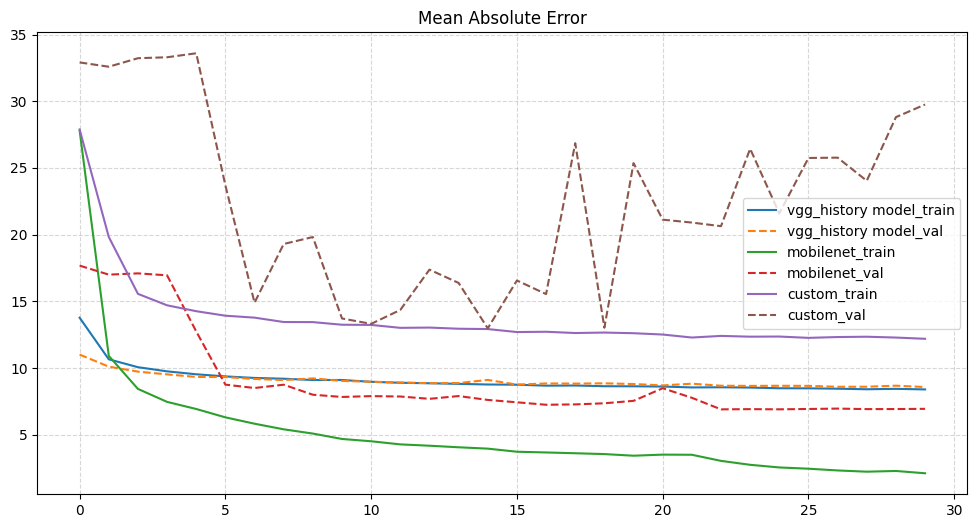

In [7]:
import pickle

with open('/kaggle/input/vgg-mobinet/vgg_training_history (1).pkl', 'rb') as f:
    vgg_history = pickle.load(f)

with open('/kaggle/input/vgg-mobinet/mobilenet_training_history (1).pkl', 'rb') as f:
    mobilenet_history = pickle.load(f)

with open('/kaggle/input/custom-simple-model-reg/custom_cnn_training_history.pkl', 'rb') as f:
    custom_history = pickle.load(f)
plt.figure(figsize=(12, 6))

plt.grid(True, linestyle='--', alpha=0.5)

plt.plot(vgg_history['mean_absolute_error'], label='vgg_history model_train')
plt.plot(vgg_history['val_mean_absolute_error'], '--', label='vgg_history model_val')

plt.plot(mobilenet_history['mae'], label='mobilenet_train')
plt.plot(mobilenet_history['val_mae'], '--', label='mobilenet_val')

plt.plot(custom_history['mean_absolute_error'], label='custom_train')
plt.plot(custom_history['val_mean_absolute_error'], '--', label='custom_val')

plt.title('Mean Absolute Error')
plt.legend()
plt.show()

**Підсумкові результати моделей за MAE**

In [8]:
print("=== VGG Model ===")
print(f"Train MAE (last epoch): {vgg_history['mean_absolute_error'][-1]:.4f}")
print(f"Val MAE (last epoch):   {vgg_history['val_mean_absolute_error'][-1]:.4f}")

print("\n=== MobileNet Model ===")
print(f"Train MAE (last epoch): {mobilenet_history['mae'][-1]:.4f}")
print(f"Val MAE (last epoch):   {mobilenet_history['val_mae'][-1]:.4f}")

print("\n=== Custom CNN Model ===")
print(f"Train MAE (last epoch): {custom_history['mean_absolute_error'][-1]:.4f}")
print(f"Val MAE (last epoch):   {custom_history['val_mean_absolute_error'][-1]:.4f}")


=== VGG Model ===
Train MAE (last epoch): 8.3894
Val MAE (last epoch):   8.5703

=== MobileNet Model ===
Train MAE (last epoch): 2.1009
Val MAE (last epoch):   6.9348

=== Custom CNN Model ===
Train MAE (last epoch): 12.1865
Val MAE (last epoch):   29.7571


**Візуалізація роботи регресійної моделі MobileNet на тестових даних**

106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step
(3369,)
Графік зараз з'явиться


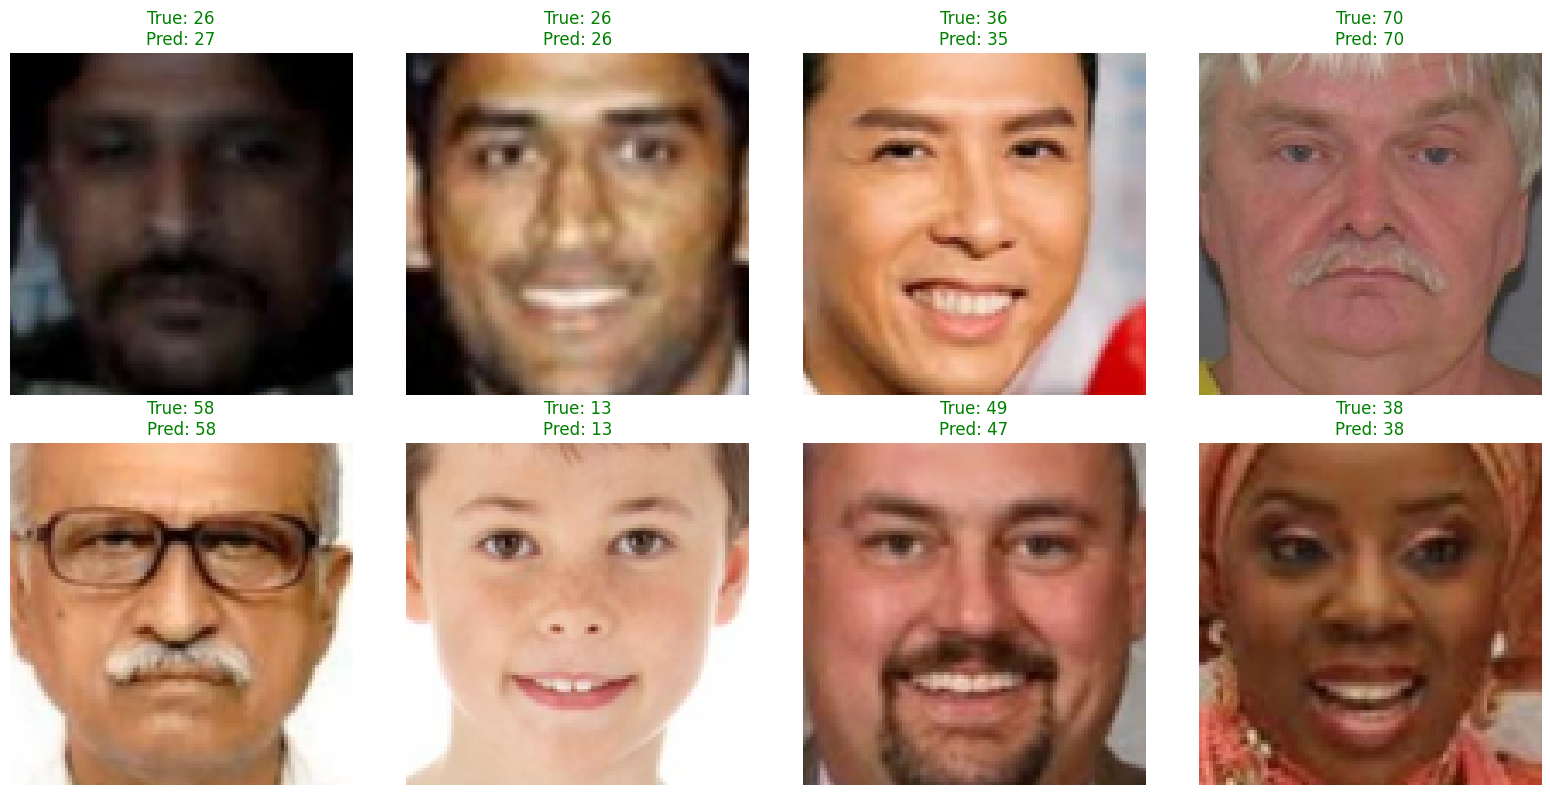

In [27]:
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
import pickle

model_mobilenet_reg = load_model('/kaggle/input/vgg-mobinet/mobilenet_age_regression (1).h5')

with open('/kaggle/input/vgg-mobinet/mobilenet_training_history (1).pkl', 'rb') as f:
    history_mobilenet_reg = pickle.load(f)

predicted_ages = model_mobilenet_reg.predict(X_test).flatten()

true_ages = Y_test.flatten()

indices = random.sample(range(len(X_test)), 8)

plt.figure(figsize=(16, 8))

for i, idx in enumerate(indices):
    plt.subplot(2, 4, i + 1)
    plt.imshow(X_test[idx])
    plt.axis('off')
    plt.title(f"True: {int(true_ages[idx])}\nPred: {int(predicted_ages[idx])}",
              color='green' if abs(true_ages[idx] - predicted_ages[idx]) < 5 else 'red')

plt.tight_layout()
print(predicted_ages.shape)
plt.show()

**Візуалізація метрик навчання моделі MobileNet для задачі класифікації**

[0.10804393142461777, 0.3585633635520935, 0.39210447669029236, 0.37666964530944824, 0.4298011362552643, 0.4384090304374695, 0.44078361988067627, 0.48233896493911743, 0.4624517560005188, 0.36628079414367676, 0.4680914282798767, 0.4585930407047272, 0.4772929549217224, 0.5218165516853333, 0.5244879722595215, 0.5357673168182373, 0.5301276445388794, 0.5268625617027283, 0.5402196645736694, 0.5354704856872559, 0.5414069294929504, 0.5488275289535522, 0.5369545817375183, 0.5402196645736694, 0.5375482439994812, 0.5431879162788391, 0.5443751811981201, 0.5446720123291016, 0.5443751811981201, 0.5479370951652527, 0.5458592772483826, 0.544968843460083, 0.5473434329032898, 0.5482339262962341, 0.5488275289535522, 0.546156108379364, 0.5479370951652527, 0.5476402640342712, 0.5455625057220459, 0.5470466017723083]


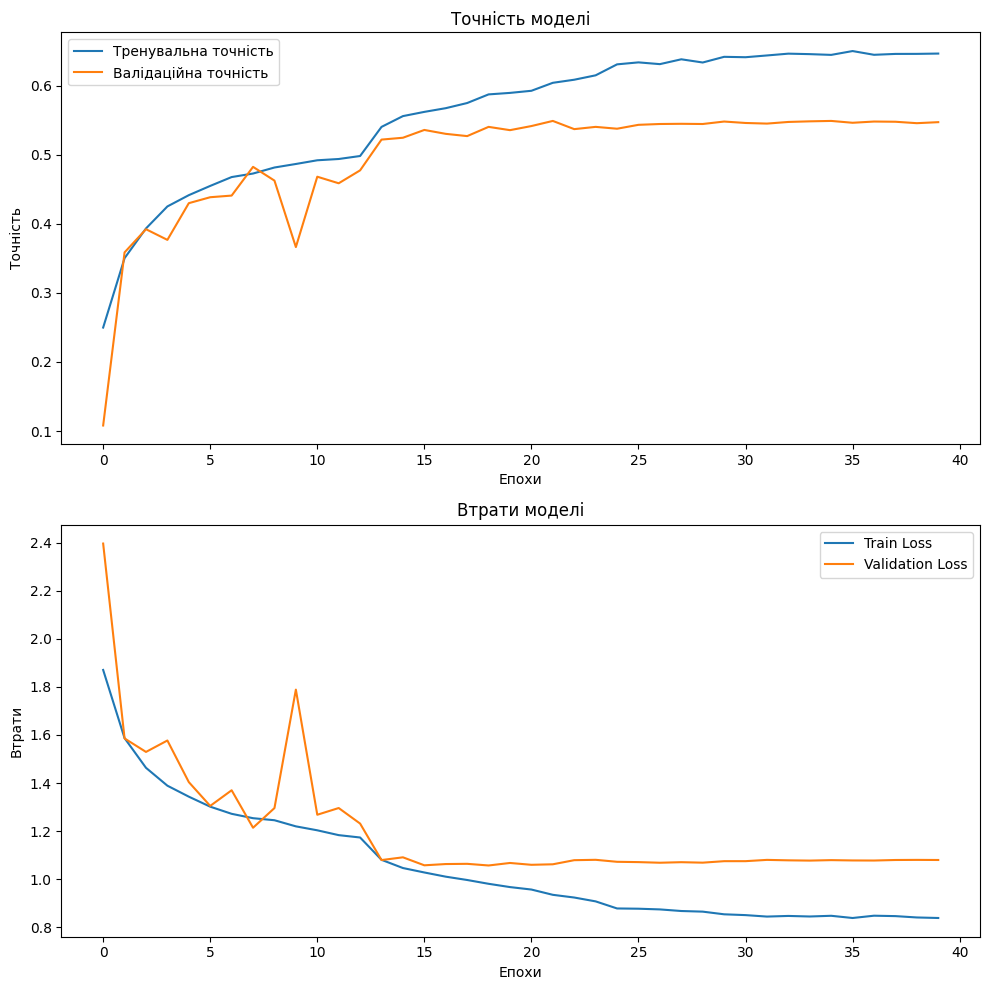

In [11]:

model_mobilenet = load_model('/kaggle/input/mobilet-class-54-150/mobilenet_clas_regression (2).h5')

# Завантаження історії тренування (перевір точну назву файлу!)
with open('/kaggle/input/mobilet-class-54-150/mobilenet_model_clas_history.pkl', 'rb') as f:
    history_mobilenet_clas = pickle.load(f)
    
# Отримуємо дані для точності та втрат з історії тренування
train_accuracy = history_mobilenet_clas['accuracy']
val_accuracy = history_mobilenet_clas['val_accuracy']
train_loss = history_mobilenet_clas['loss']
val_loss = history_mobilenet_clas['val_loss']

plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(train_accuracy, label='Тренувальна точність')
plt.plot(val_accuracy, label='Валідаційна точність')
plt.title('Точність моделі')
plt.xlabel('Епохи')
plt.ylabel('Точність')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Втрати моделі')
plt.xlabel('Епохи')
plt.ylabel('Втрати')
plt.legend()

plt.tight_layout()
plt.show()

**Візуалізація роботи моделі класифікації MobileNet на тестових даних**

In [10]:
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
import pickle

model_mobilenet = load_model('/kaggle/input/mobilenet-class-56/mobilenet_clas_regression (3).h5')

with open('/kaggle/input/mobilenet-class-56/mobilenet_model_clas_history (1).pkl', 'rb') as f:
    history_mobilenet_clas = pickle.load(f)

predictions = model_mobilenet.predict(X_test)

true_labels = np.argmax(Y_test_encoded, axis=1)
predicted_labels = np.argmax(predictions, axis=1)

age_bins_labels = [
    '1–9 років', '10–20 років', '21–26 років', '27–34 років',
    '35–45 років', '45–60 років', '60–99 років'
]

indices = random.sample(range(len(X_test)), 8)

plt.figure(figsize=(16, 8))

for i, idx in enumerate(indices):
    plt.subplot(2, 4, i + 1)
    plt.imshow(X_test[idx])
    plt.axis('off')
    plt.title(f"True: {age_bins_labels[true_labels[idx]]}\nPred: {age_bins_labels[predicted_labels[idx]]}",
              color='green' if true_labels[idx] == predicted_labels[idx] else 'red')

plt.tight_layout()
print(predictions.shape)  # має бути (кількість_зразків, 7)
print("Графік зараз з'явиться")
plt.show()

106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 312ms/step
(3369, 7)
Графік зараз з'явиться


**Оцінка якості класифікації вікових груп: F1-метрики та візуалізація матриці невідповідностей**

106/106 ━━━━━━━━━━━━━━━━━━━━ 32s 297ms/step
F1-score (macro): 0.5752
F1-score (weighted): 0.5602


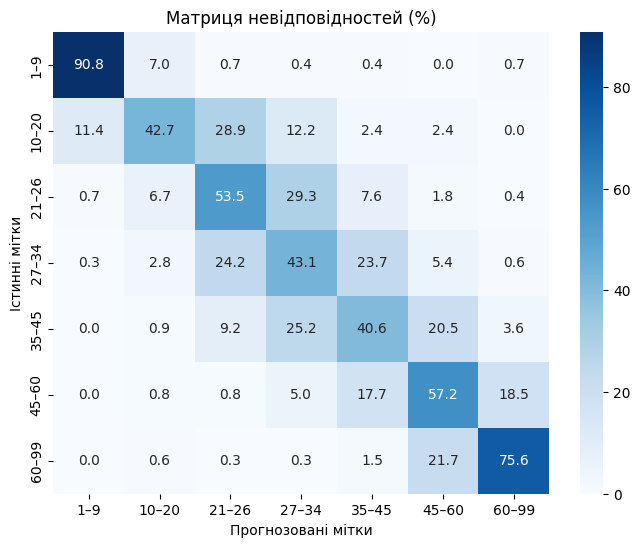

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

age_bins_labels = [
    '1–9', '10–20', '21–26', '27–34',
    '35–45', '45–60', '60–99'
]

Y_pred = model_mobilenet.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test_encoded, axis=1)

from sklearn.metrics import classification_report, f1_score

# Обчислення F1-score
f1_macro = f1_score(Y_true, Y_pred_classes, average='macro')
f1_weighted = f1_score(Y_true, Y_pred_classes, average='weighted')

print(f"F1-score (macro): {f1_macro:.4f}")
print(f"F1-score (weighted): {f1_weighted:.4f}")

conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.1f', cmap='Blues', 
            xticklabels=age_bins_labels, yticklabels=age_bins_labels)

plt.xlabel('Прогнозовані мітки')
plt.ylabel('Істинні мітки')
plt.title('Матриця невідповідностей (%)')
plt.show()

**Візуалізація метрик навчання моделі MobileNet для задачі класифікації із застосуванням балансування класів**

[0.10388839244842529, 0.36182844638824463, 0.35529831051826477, 0.43633124232292175, 0.41792815923690796, 0.4387058615684509, 0.43811219930648804, 0.41911545395851135, 0.4108043909072876, 0.44197091460227966, 0.4033837914466858, 0.4716533124446869, 0.444048672914505, 0.47016918659210205, 0.43929949402809143, 0.4956960380077362, 0.44939151406288147, 0.45978033542633057, 0.4974769949913025, 0.4238646626472473, 0.50400710105896, 0.5004452466964722, 0.5158801078796387, 0.49955475330352783, 0.5428910851478577, 0.4749183654785156, 0.5111309289932251, 0.5283467173576355, 0.5057880878448486, 0.5307213068008423, 0.5497180223464966, 0.5621846318244934, 0.5553576946258545, 0.5529831051826477, 0.5592163801193237, 0.5559512972831726, 0.5544672012329102, 0.5693084001541138, 0.5601068735122681, 0.5607004761695862]
[0.235163152217865, 0.3344570994377136, 0.38127344846725464, 0.4102156460285187, 0.42128363251686096, 0.43152472376823425, 0.44570955634117126, 0.45251575112342834, 0.46415621042251587, 0.4

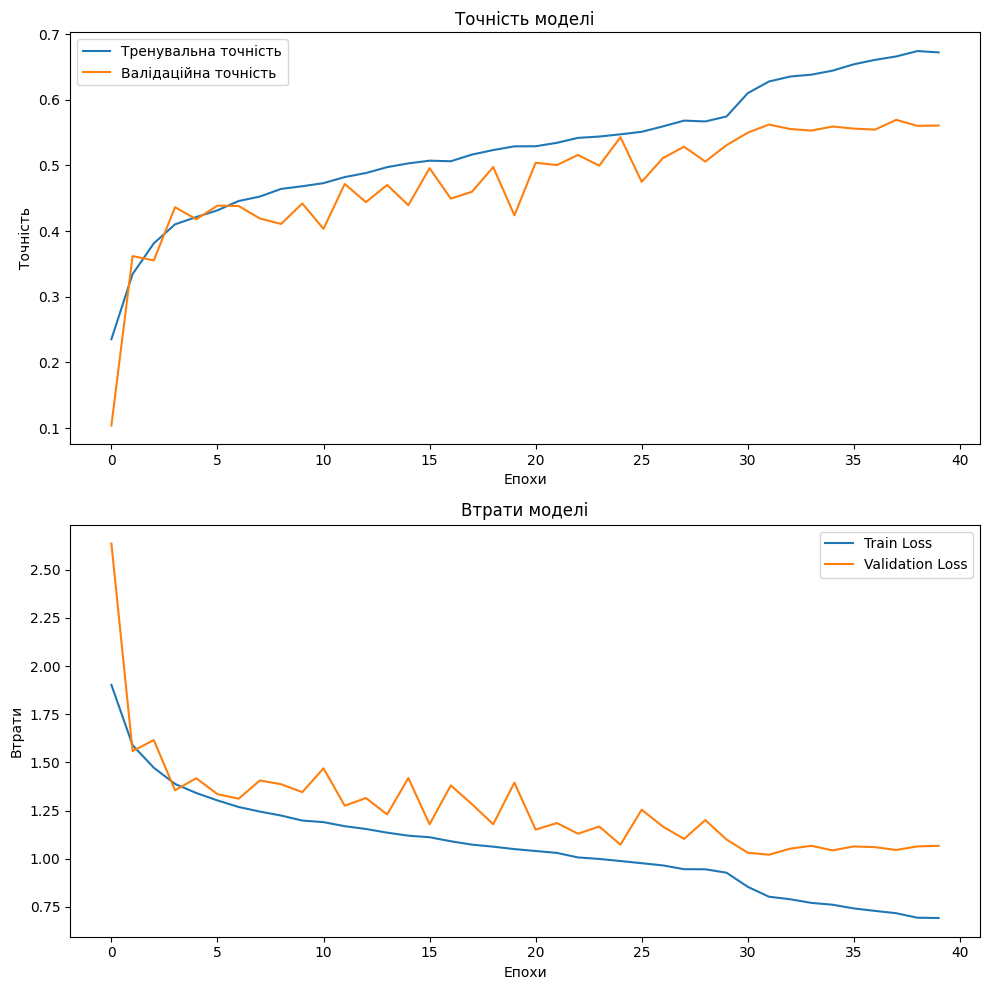

In [13]:
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
import pickle
model_mobilenet_balanced = load_model('/kaggle/input/mobilenet-class-56/mobilenet_clas_regression (3).h5')

with open('/kaggle/input/mobilenet-class-56/mobilenet_model_clas_history (1).pkl', 'rb') as f:
    history_mobilenet_clas_balanced = pickle.load(f)
    
train_accuracy = history_mobilenet_clas_balanced['accuracy']
val_accuracy = history_mobilenet_clas_balanced['val_accuracy']
train_loss = history_mobilenet_clas_balanced['loss']
val_loss = history_mobilenet_clas_balanced['val_loss']

plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(train_accuracy, label='Тренувальна точність')
plt.plot(val_accuracy, label='Валідаційна точність')
plt.title('Точність моделі')
plt.xlabel('Епохи')
plt.ylabel('Точність')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Втрати моделі')
plt.xlabel('Епохи')
plt.ylabel('Втрати')
plt.legend()

plt.tight_layout()
plt.show()

**Оцінка якості класифікації вікових груп після балансування: F1-метрики та візуалізація матриці невідповідностей**

106/106 ━━━━━━━━━━━━━━━━━━━━ 32s 291ms/step
F1-score (macro): 0.5735
F1-score (weighted): 0.5527


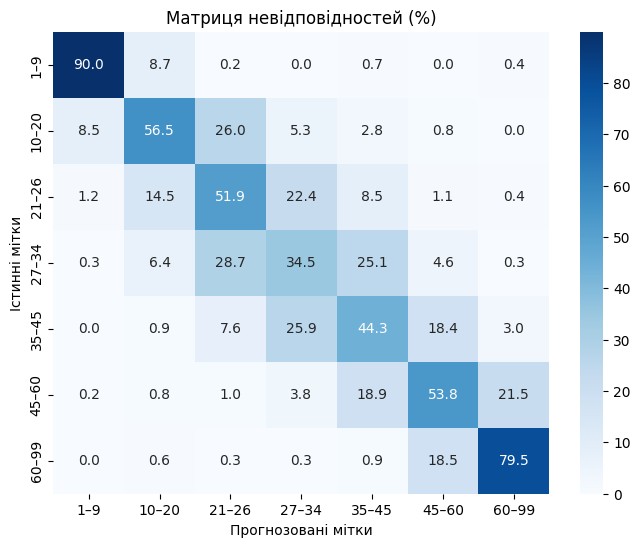

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

age_bins_labels = [
    '1–9', '10–20', '21–26', '27–34',
    '35–45', '45–60', '60–99'
]

Y_pred = model_mobilenet_balanced.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test_encoded, axis=1)

from sklearn.metrics import classification_report, f1_score

# Обчислення F1-score
f1_macro = f1_score(Y_true, Y_pred_classes, average='macro')
f1_weighted = f1_score(Y_true, Y_pred_classes, average='weighted')

print(f"F1-score (macro): {f1_macro:.4f}")
print(f"F1-score (weighted): {f1_weighted:.4f}")

conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.1f', cmap='Blues', xticklabels=age_bins_labels, 
            yticklabels=age_bins_labels)

plt.xlabel('Прогнозовані мітки')
plt.ylabel('Істинні мітки')
plt.title('Матриця невідповідностей (%)')
plt.show()
